#**Importing Libraries**


In [1]:
import pandas as pd
import seaborn as sns
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk import pos_tag, word_tokenize
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import svm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,confusion_matrix

#**Data Collection & Pre-Processing**

In [2]:
df1 = pd.read_csv("spam.csv" , encoding = "latin-1")

In [3]:
df1.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [4]:
df1 = df1[['v1', 'v2']]
df1 = df1.rename(columns = {'v1': 'target', 'v2': 'text'})

In [5]:
df1.head()

,target,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [6]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   target  5572 non-null   object
 1   text    5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


In [7]:
from sklearn import preprocessing

In [8]:
#Encoding Spam to 1 and ham to 0
df1['target'] = df1['target'].apply(lambda x: 1 if x == 'spam' else 0)

In [9]:
df1.head()

,target,text
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [10]:
# missing values
df1.isnull().sum()

target    0
text      0
dtype: int64

In [11]:
#Duplicate values
df1.duplicated().sum()

403

In [12]:
# remove the duplicates
df1 = df1.drop_duplicates(keep = 'first')

In [13]:
df1.duplicated().sum()

0

In [14]:
df1.shape

(5169, 2)

## **EDA**

In [15]:
df1.head()

,target,text
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [16]:
df1['target'].value_counts()

0    4516
1     653
Name: target, dtype: int64

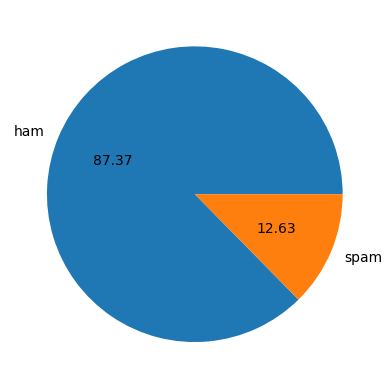

In [17]:
import matplotlib.pyplot as plt
plt.pie(df1['target'].value_counts(), labels = ['ham', 'spam'], autopct = "%0.2f")
plt.show()

In [18]:
# Data is imbalanced
# Adding extra dataset to make it somewhat balanced


In [19]:
df2= pd.read_csv("smsdataset.csv" , encoding = "latin-1")

In [20]:
df2.head()

,v1,v2
0,spam,U were outbid by simonwatson5120 on the Shinco...
1,ham,Do you still have the grinder?
2,ham,No. Yes please. Been swimming?
3,ham,No de.am seeing in online shop so that i asked.
4,ham,"Faith makes things possible,Hope makes things ..."


In [21]:
df2.isnull().sum()

v1    0
v2    0
dtype: int64

In [22]:
df2.duplicated().sum()

264

In [23]:
df2= df2.drop_duplicates(keep = 'first')

In [24]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4193 entries, 0 to 4455
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   v1      4193 non-null   object
 1   v2      4193 non-null   object
dtypes: object(2)
memory usage: 98.3+ KB


In [25]:
df2 = df2.rename(columns = {'v1': 'target', 'v2': 'text'})

In [26]:
df2['target'] = df2['target'].apply(lambda x: 1 if x == 'spam' else 0)

In [27]:
df2['target'].value_counts()

0    3659
1     534
Name: target, dtype: int64

In [28]:
spam_df = df2[df2['target'] == 1]

In [29]:
spam_df.head()

,target,text
0,1,U were outbid by simonwatson5120 on the Shinco...
9,1,December only! Had your mobile 11mths+? You ar...
15,1,"UpgrdCentre Orange customer, you may now claim..."
19,1,YOUR CHANCE TO BE ON A REALITY FANTASY SHOW ca...
29,1,Double mins and txts 4 6months FREE Bluetooth ...


In [30]:
df = pd.concat([df1, spam_df], ignore_index=True)


In [31]:
df

,target,text
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5698,1,"Do you ever notice that when you're driving, a..."
5699,1,"You have won ?1,000 cash or a ?2,000 prize! To..."
5700,1,IMPORTANT MESSAGE. This is a final contact att...
5701,1,FreeMsg Hi baby wow just got a new cam moby. W...


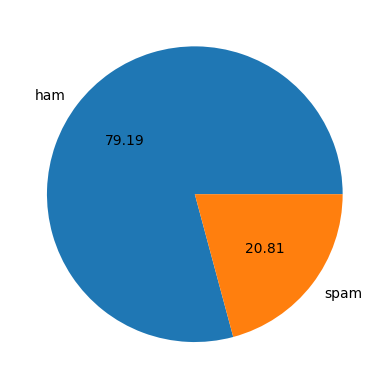

In [32]:
plt.pie(df['target'].value_counts(), labels = ['ham', 'spam'], autopct = "%0.2f")
plt.show()

In [33]:
#IMPROVED SPAM PERCENTAGE 15 TO ALMOST 25
#REMAINING IMBALANCE WILL BE TAKEN CARE BY SMOTE

In [34]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [35]:
df['num_characters'] = df['text'].apply(len)

In [36]:
df.head()

,target,text,num_characters
0,0,"Go until jurong point, crazy.. Available only ...",111
1,0,Ok lar... Joking wif u oni...,29
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,0,U dun say so early hor... U c already then say...,49
4,0,"Nah I don't think he goes to usf, he lives aro...",61


In [37]:
#number of words
df['num_words'] = df['text'].apply(lambda x: len(nltk.word_tokenize(x)))

In [38]:
df.head()

,target,text,num_characters,num_words
0,0,"Go until jurong point, crazy.. Available only ...",111,24
1,0,Ok lar... Joking wif u oni...,29,8
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,37
3,0,U dun say so early hor... U c already then say...,49,13
4,0,"Nah I don't think he goes to usf, he lives aro...",61,15


In [39]:
df['num_sentences'] = df['text'].apply(lambda x: len(nltk.sent_tokenize(x)))

In [40]:
df.head()

,target,text,num_characters,num_words,num_sentences
0,0,"Go until jurong point, crazy.. Available only ...",111,24,2
1,0,Ok lar... Joking wif u oni...,29,8,2
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,37,2
3,0,U dun say so early hor... U c already then say...,49,13,1
4,0,"Nah I don't think he goes to usf, he lives aro...",61,15,1


In [41]:
df.describe()

,target,num_characters,num_words,num_sentences
count,5703.000000,5703.000000,5703.000000,5703.000000
mean,0.208136,84.590391,19.327196,2.062073
std,0.406010,58.885467,13.152916,1.484045
min,0.000000,2.000000,1.000000,1.000000
25%,0.000000,38.000000,9.000000,1.000000
50%,0.000000,67.000000,16.000000,2.000000
75%,0.000000,133.000000,28.000000,3.000000
max,1.000000,910.000000,220.000000,38.000000


In [42]:
# ham messages
df[df['target'] == 0].describe()

,target,num_characters,num_words,num_sentences
count,4516.0,4516.000000,4516.000000,4516.000000
mean,0.0,70.459256,17.123782,1.820195
std,0.0,56.358207,13.493970,1.383657
min,0.0,2.000000,1.000000,1.000000
25%,0.0,34.000000,8.000000,1.000000
50%,0.0,52.000000,13.000000,1.000000
75%,0.0,90.000000,22.000000,2.000000
max,0.0,910.000000,220.000000,38.000000


In [43]:
#spam messages
df[df['target'] == 1].describe()

,target,num_characters,num_words,num_sentences
count,1187.0,1187.000000,1187.000000,1187.000000
mean,1.0,138.352991,27.710194,2.982308
std,0.0,30.429709,7.051742,1.493276
min,1.0,13.000000,2.000000,1.000000
25%,1.0,132.000000,25.000000,2.000000
50%,1.0,149.000000,29.000000,3.000000
75%,1.0,158.000000,32.000000,4.000000
max,1.0,226.000000,46.000000,9.000000


If we look at the mean values than clearly we can see that mostly spam messages are longer in length

In [44]:
import seaborn as sns

<Axes: xlabel='num_characters', ylabel='Count'>

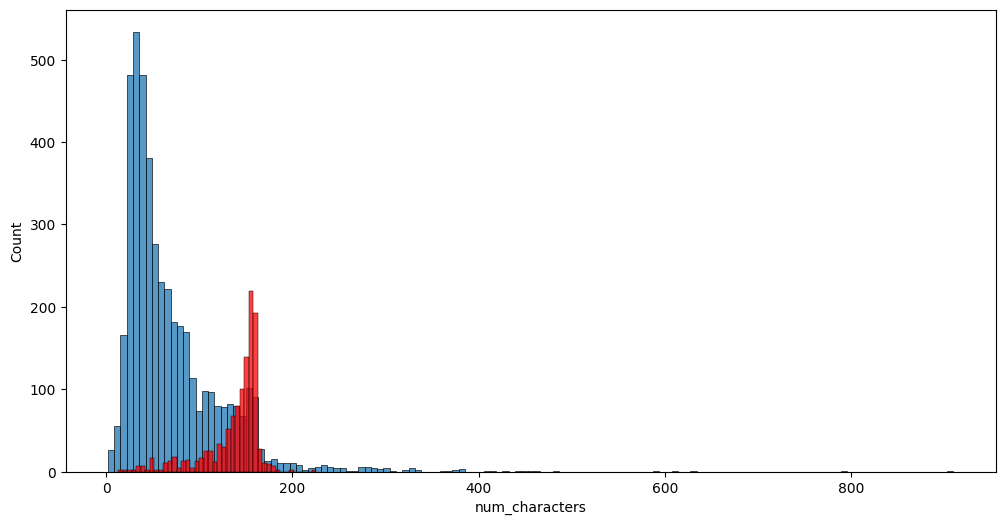

In [45]:
plt.figure(figsize = (12, 6))
sns.histplot(df[df['target'] == 0]['num_characters'])
sns.histplot(df[df['target'] == 1]['num_characters'], color = 'red')

<Axes: xlabel='num_words', ylabel='Count'>

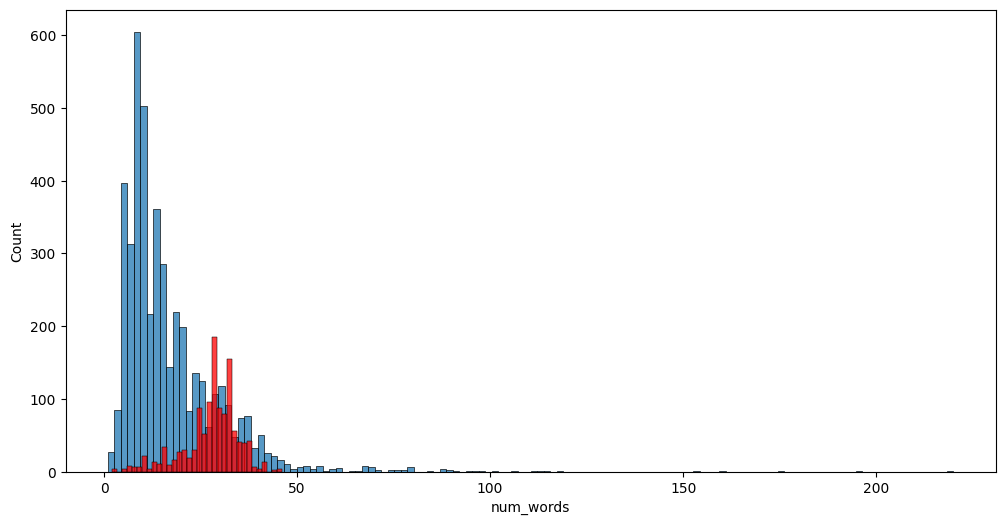

In [46]:
plt.figure(figsize = (12, 6))
sns.histplot(df[df['target'] == 0]['num_words'])
sns.histplot(df[df['target'] == 1]['num_words'], color = 'red')

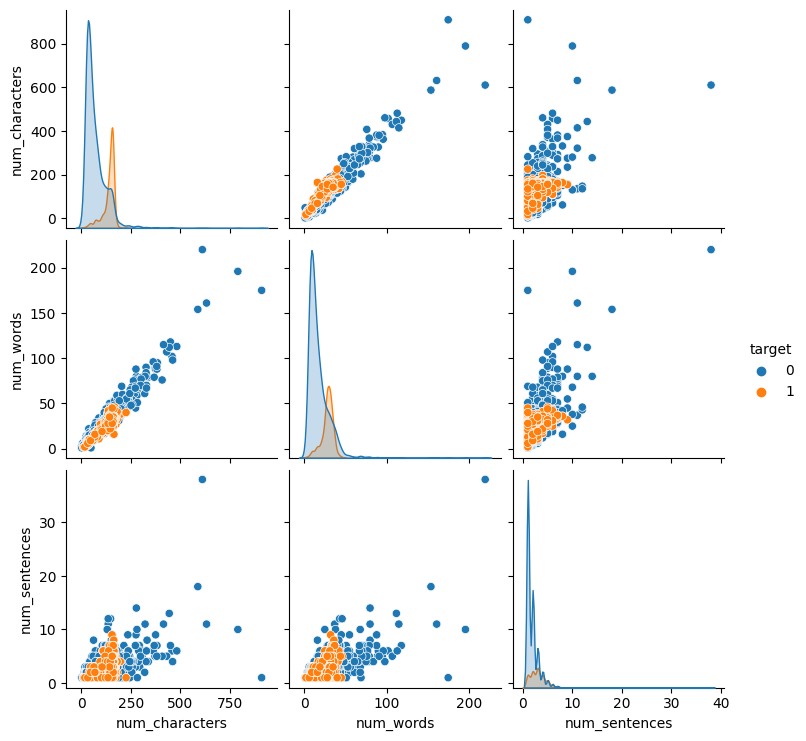

In [47]:
sns.pairplot(df, hue = 'target')

In [48]:
df.corr()

<ipython-input-48-2f6f6606aa2c>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df.corr()


,target,num_characters,num_words,num_sentences
target,1.000000,0.468122,0.326786,0.317935
num_characters,0.468122,1.000000,0.960711,0.621341
num_words,0.326786,0.960711,1.000000,0.673360
num_sentences,0.317935,0.621341,0.673360,1.000000


<ipython-input-49-fe43fffaf13b>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr(), annot = True)


<Axes: >

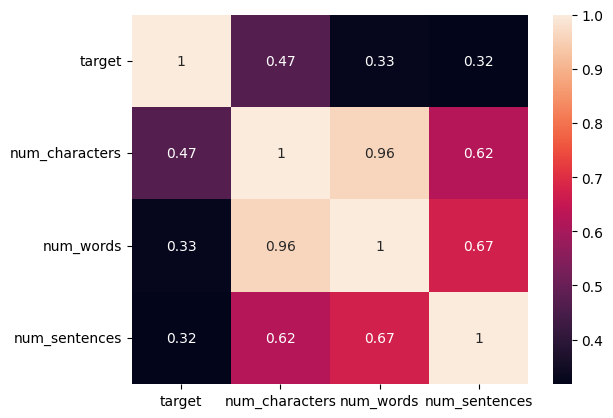

In [49]:
sns.heatmap(df.corr(), annot = True)

## **Data Preprocessing**

Lower case

Removing stop words and punctuation

Stemming

In [50]:
from nltk import stem
nltk.download('stopwords')
from nltk.corpus import stopwords
import string
stemmer = stem.SnowballStemmer('english')
stopwords = set(stopwords.words('english'))


def transform_text(msg):
    # converting messages to lowercase
    msg = msg.lower()
    # removing stopwords
    msg = [word for word in msg.split() if word not in stopwords]
    # using a stemmer
    msg = " ".join([stemmer.stem(word) for word in msg])
    # removing punctuation
    for punctuation in string.punctuation:
      msg = msg.replace(punctuation, '')
    return msg

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [51]:
transform_text("Go until jurong point#, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat..")

'go jurong point crazy avail bugi n great world la e buffet cine got amor wat'

In [52]:
df['transformed_text'] = df['text'].apply(transform_text)

In [53]:
df.head()

,target,text,num_characters,num_words,num_sentences,transformed_text
0,0,"Go until jurong point, crazy.. Available only ...",111,24,2,go jurong point crazy avail bugi n great world...
1,0,Ok lar... Joking wif u oni...,29,8,2,ok lar joke wif u oni
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,37,2,free entri 2 wkli comp win fa cup final tkts 2...
3,0,U dun say so early hor... U c already then say...,49,13,1,u dun say earli hor u c alreadi say
4,0,"Nah I don't think he goes to usf, he lives aro...",61,15,1,nah think goe usf live around though


In [54]:
from wordcloud import WordCloud
wc = WordCloud(width=500,height=500,min_font_size=10,background_color='white')

In [55]:
spam_wc = wc.generate(df[df['target'] == 1]['transformed_text'].str.cat(sep=" "))

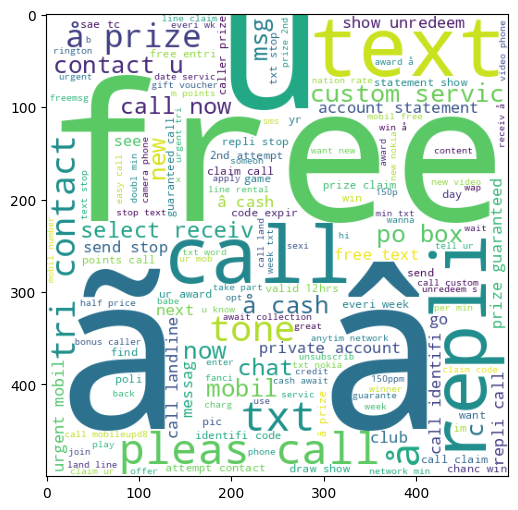

In [56]:
plt.figure(figsize=(15,6))
plt.imshow(spam_wc)

In [57]:
ham_wc = wc.generate(df[df['target'] == 0]['transformed_text'].str.cat(sep=" "))

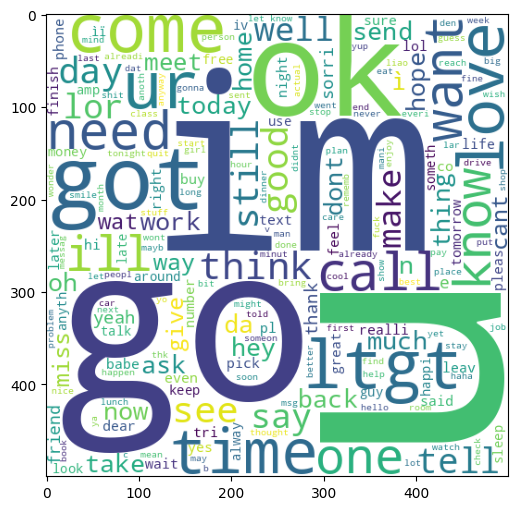

In [58]:
plt.figure(figsize=(15,6))
plt.imshow(ham_wc)

## **4. Model Building**

In [59]:
from sklearn.model_selection import train_test_split

In [60]:
X_train, X_test, y_train, y_test = train_test_split(df['transformed_text'], df['target'], test_size = 0.1, random_state = 1)

In [61]:
# training the vectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

In [62]:
from imblearn.over_sampling import SMOTE

In [63]:
# Applying SMOTE to increase the number of 'spam' samples
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

In [64]:
y_train.value_counts()

0    4079
1    1053
Name: target, dtype: int64

In [65]:
y_train_resampled.value_counts()

0    4079
1    4079
Name: target, dtype: int64

In [66]:
param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': [0.1, 1, 'scale', 'auto'],
    'degree': [2, 3]
}

In [67]:
from sklearn import svm
svm = svm.SVC()


In [68]:
grid_search = GridSearchCV(svm, param_grid, cv=5, scoring='accuracy')

In [69]:
grid_search.fit(X_train_resampled, y_train_resampled)

GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [0.1, 1, 10], 'degree': [2, 3],
                         'gamma': [0.1, 1, 'scale', 'auto'],
                         'kernel': ['linear', 'rbf']},
             scoring='accuracy')

In [70]:
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

In [71]:
y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print("Best Hyperparameters:", best_params)
print("Test Accuracy:", accuracy)

Best Hyperparameters: {'C': 10, 'degree': 2, 'gamma': 'scale', 'kernel': 'rbf'}
Test Accuracy: 0.9982486865148862


In [72]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score


In [73]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)


In [74]:
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("ROC AUC:", roc_auc)

Accuracy: 0.9982486865148862
Precision: 1.0
Recall: 0.9925373134328358
F1 Score: 0.9962546816479401
ROC AUC: 0.9962686567164178


In [75]:
# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[437   0]
 [  1 133]]


In [76]:
#Testing our own sentence
def predict_ham_or_spam(sentence):

    sentence_tfidf = vectorizer.transform([sentence])

    prediction = best_model.predict(sentence_tfidf)

    label = "spam" if prediction[0] == 1 else "ham"

    return label

In [77]:
# Test with your own sentences
sentence1 = "Hello, You have a schedule meeting at 10pm."
sentence2 = "Congratulations! You've won a prize. Call now to claim."

In [78]:
result1 = predict_ham_or_spam(sentence1)
result2 = predict_ham_or_spam(sentence2)

print(f"Sentence 1: {sentence1} => Prediction: {result1}")
print(f"Sentence 2: {sentence2} => Prediction: {result2}")

Sentence 1: Hello, You have a schedule meeting at 10pm. => Prediction: ham
Sentence 2: Congratulations! You've won a prize. Call now to claim. => Prediction: spam
